# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse
import cv2

import sys
# import theano
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils

print('Keras ', keras.__version__)
# print('Theano', theano.__version__)
print('TensorFlow', tf.__version__)
print('OpenCV', cv2.__version__)
print('Numpy ', np.__version__)

Using TensorFlow backend.


Keras  2.0.4
TensorFlow 1.1.0
OpenCV 3.2.0-dev
Numpy  1.12.1


In [3]:
import keras.backend as K

K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:     {}'.format(K.backend()))
print('Data format: {}'.format(K.image_data_format()))


Backend:     tensorflow
Data format: channels_first


In [4]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


In [ ]:
model_name = '../../models/keras_lenet_1'

class MyLeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, (5, 5), padding="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


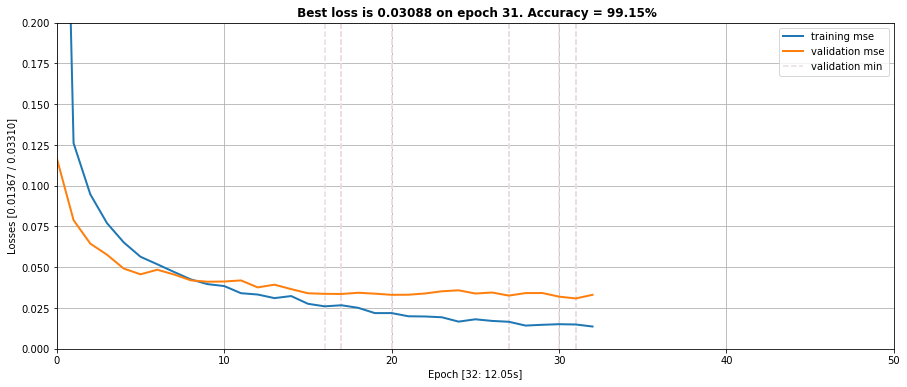

In [ ]:
nepochs = 50
ploss = 0.2

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = MyLeNet.build(width=28, height=28, depth=1, classes=10)
    
    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nepochs)
plot.grid(True)

print("[INFO] training...")
try:
    histo2 = model.fit(X_train, y_train, batch_size=128, epochs=nepochs - past_epochs, 
                       verbose=0, validation_split=0.33, callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating in the test data set ...")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy on the test data set: {:.2f}%".format(accuracy * 100))


In [ ]:

print(y_test.shape)

vreal = np.argmax(y_test,axis=1)
print(vreal[:10])

vpred = model.predict_classes(X_test,verbose=0)
print(vpred.shape)
print(vpred[:10])

ii = np.where(vpred!=vreal)[0]
print(ii, len(ii))
print(type(ii))

In [ ]:
# randomly select a few testing digits
plot.figure(figsize=(12, 12))


#for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(20,))):
for k, i in enumerate(ii[:40]):
    plot.subplot(8, 5, k + 1)
    # classify the digit
    probs = model.predict(X_test[np.newaxis, i])
    prediction = probs.argmax(axis=1)

    # resize the image from a 28 x 28 image to a 96 x 96 image so we
    # can better see it
    image = (X_test[i][0] * 255).astype("uint8")
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(prediction[0]), (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
                (0, 255, 0), 2)

    # show the image and prediction
    vreal = np.argmax(y_test[i])
    # print("[INFO] Predicted: {}, Actual: {}".format(prediction[0], vreal))
    plot.imshow(image)
    plot.axis('off')
    plot.title('{}'.format(vreal))


## Atividades

1. Calcular o número de parâmetros a serem treinados nesta rede
2. Mostrar a matriz de confusão da rede aplicada no conjunto de testes
2. Mostrar as imagens classificadas erroneamente

## Aprendizados com este notebook
